# Baseline Models

We will develop the baseline neural network model (one hidden layer, 3-node softmax output) for comparisons for later architectures.

In [17]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
# Reading in Data
data_path = 'data/merged.csv'
data = pd.read_csv(data_path)

In [3]:
# Function to convert data to classification
def label_type(row):
    """ Converts continuous label to categorical label
    """
    if row['scaled_effect'] < .99:
        return('Deleterious')
    elif row['scaled_effect'] > 1.1:
        return('Beneficial')
    else:
        return('Netural')

In [4]:
# Change to classification
data['type'] = data.apply(lambda row: label_type(row), axis = 1)
data_final = data.drop(['scaled_effect'], axis=1)

In [5]:
# LOPO Splitting
def train_test_split(protein, curr_data):
    train_data = curr_data[data.protein != protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    test_data = curr_data[data.protein == protein].drop(['protein', 'pdb', 'resnum'], axis=1)
    
    y_train = train_data.type
    x_train = train_data.drop(['type'], axis=1)
    y_test = test_data.type
    x_test = test_data.drop(['type'], axis=1)

    return x_train, y_train, x_test, y_test

In [7]:
x_train, y_train, x_test, y_test = train_test_split('PSD95pdz3', data_final)

In [19]:
# Baseline Model
def baseline_model():
    model = Sequential()
    model.add(Dense(800, input_dim = 968, activation = 'relu'))
    model.add(Dense(3, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate = 0.1)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return(model)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.529187798500061
Precision: 0.41648693985142576


NameError: name 'protein' is not defined

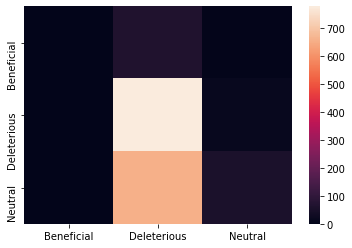

In [21]:
# Baseline Analysis
def baseline(protein):
    # Split Training Data based on Protein
    x_train, y_train, x_test, y_test = train_test_split(protein, data_final)
    
    # Build Model
    # 40 epochs based on initial runs and graphing of loss over time.
    estimator = KerasClassifier(build_fn=base_model, epochs=40, batch_size=10, verbose=1)
    estimator.fit(x_train, y_train, verbose=1)
    
    # Generate Analysis Characteristics
    probs = estimator.predict_proba(x_test)
    predictions = estimator.predict(x_test)
    precision = precision_score(y_test, predictions, average="macro")
    score = estimator.score(x_test, y_test)

    print('Accuracy: {}'.format(score))
    print('Precision: {}'.format(precision))
    
    # Plotting Confusion Matrices
    cmatrix = confusion_matrix(y_test, predictions)
    fig, ax = plt.subplots()
    sns.heatmap(cmatrix, xticklabels = ['Beneficial', 'Deleterious', 'Neutral'], yticklabels = ['Beneficial', 'Deleterious', 'Neutral'])
    ax.set_title('{}'.format(protein))
    plt.savefig('img/' + protein + '-baseline-cmatrix.png', dpi=300)